# Brief:

In this notebook, by using highly imbalanced credit card fraud data, we explore if Data Balancing or Model Calibration will help improve our Random Forest based classificaiton model.

#### We demonstrated techniques listed below:

    1. Grid Search for optimal random forest parameters
    2. Confusion Matrix
    3. Normalized Confusion Matrix (unbalanced test data)
    4. Cross-validation Score + Testing Accuracy/F1 Score
    5. Classification Report
    6. Precison-Recall Curve
    7. ROC and AUC
    8. Calibration Curve/ Reliability Diagram
    9. Calibrated Model improvement
    

#### Conclusion:

In our randome forest model:
    1. Grid-search Cross-Validation chose to use unbalanced training data and minimize entropy to come up a model with the     highest f1-score.
    2. Calibrated model didn't improve calibration over test data
    3. However, Calibrated model does bring better model performance by observing ROC curve and Precision-Recall curve
Therefore, we will choose calibration to improve our Random Forest model performance


In [116]:
import pandas as pd
import numpy as np


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier


from sklearn.model_selection import cross_val_predict,cross_val_score,train_test_split


from sklearn.metrics import classification_report, confusion_matrix, roc_curve,auc, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.metrics import average_precision_score, f1_score

import matplotlib.pyplot as plt

from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV



In [117]:
creditcard = pd.read_csv('C:/Users/liuhu/Documents/Python/creditcard.csv')
creditcard['hour'] = creditcard['Time'].apply(lambda x: np.ceil(float(x)/3600) % 24)

In [118]:
creditcard.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,hour
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,1.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,1.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,1.0


In [6]:
# normalize/Standardize the "Amount", as its values are in very different scales to other Cols in the table. (tress based model may not need to do so)
creditcard['Amount'] = StandardScaler().fit_transform(creditcard[['Amount']])  # standardize the col and apply change

# However, in general Decision Trees requires very little data preparation. In particular, they don’t require feature scaling or centering at all.

In [7]:
# Prep training / testing tables

target=creditcard['Class']
features=creditcard.drop(['Class'], axis=1)

x_train,x_test,y_train,y_test = train_test_split(features,target, stratify=target,test_size=0.35, random_state=1)

In [8]:
# Let's store our y_test legit and fraud counts for confusion matrix normalization purposes later on
y_test_legit = y_test.value_counts()[0]
y_test_fraud = y_test.value_counts()[1]

# Random Forest Model

1. Grid Search for optimal random forest parameters
    1. Side Topic: Feature Importance
2. Confusion Matrix
3. Normalized Confusion Matrix (unbalanced test data)
4. Cross-validation Score + Testing Accuracy/F1 Score 
5. Classification Report
6. Precison-Recall Curve
7. ROC and AUC
8. Calibration Curve/ Reliability Diagram

9. Calibrated Model improvement

In [113]:
forest = RandomForestClassifier(n_estimators=50, random_state=2) # 50 trees

param_grid={'max_depth':np.arange(5,15), 'criterion':['gini','entropy'], 'class_weight':['balanced', None]} # np.arange excludes 'end'

tree_CV=GridSearchCV(forest, param_grid, scoring='f1', cv=5) # RandomizedSearchCV() can be faster when lots of Grid options
tree_CV.fit(x_train, y_train)

# Show the selected parameters
print(tree_CV.best_params_)
print(tree_CV.best_score_)

# Surprise for no need of balancing data and based on entropy minimizaion, we only need trees go maximum 6 levels
# Using 10 and 50 trees came back with the same recommendations

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 13}
0.852572038654695


In [69]:
# Takes long time for grid search, manually enter the optimized parameters from above

forest_model = RandomForestClassifier(n_estimators=10, random_state=2, max_depth=13, criterion='entropy')

forest_model_fitted=forest_model.fit(x_train, y_train)

In [115]:
# Side Note - Feature importances - top influential features:
score=forest_model_fitted.feature_importances_
name=list(creditcard)
name_array=np.asarray(name)
combine=pd.DataFrame([name_array, score]).T
combine.columns=('Name', 'Score')

print(combine.sort_values('Score', ascending=0).head())

   Name      Score
14  V14   0.227161
17  V17   0.183637
3    V3   0.102311
12  V12  0.0983151
4    V4   0.063125


In [48]:
forest_predict=forest_model.predict(x_test)

In [119]:
#1. Draw confusion matrix for analysis based on test data
#   Confusion matrix straitforwardedly tells how many are accurately classified and how many are not

confusion= confusion_matrix(y_test, forest_predict) # Unbalanced data
print("Confusion matrix Random Forest:\n{}".format(confusion));

Confusion matrix Random Forest:
[[99506     5]
 [   36   136]]


In [122]:
# To better observe confustion matrix

import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

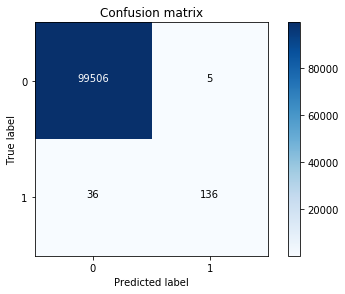

In [126]:
class_names = [0,1]
plt.figure()
plot_confusion_matrix(confusion, normalize=False , classes=class_names, title='Confusion matrix')
plt.show()

In [131]:
#2. Draw normalized confusion matrix based test data 
   # Build normalization matrix using the counts in test data for each category
    norm_matrix=np.array([[1/y_test_legit, 1/y_test_legit], [1/y_test_fraud, 1/y_test_fraud]])
    
    # normalize the unbalanced regular confusion matrix， each row sums up to 1
    confusion_norm = np.around(confusion*norm_matrix, 2)
    print("Normalized Confusion matrix with unbalanced training data:\n{}".format(confusion_norm ))
    

Normalized Confusion matrix with unbalanced training data:
[[1.   0.  ]
 [0.21 0.79]]


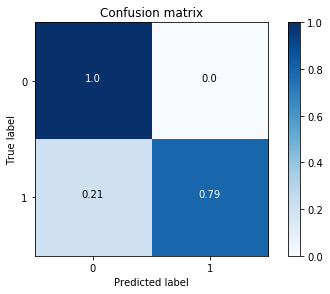

In [132]:
class_names = [0,1]
plt.figure()
plot_confusion_matrix(confusion_norm, normalize=False , classes=class_names, title='Confusion matrix')
plt.show()

In [50]:
# 3. Cross-validation score using training data and then using unseen test data for testing
forest_CV=cross_val_score(forest_model, x_train, y_train, cv=5)
print("Cross Validation using training data：")
print(forest_CV);
print("Averaged Cross Validation score:\n{}".format(np.mean(forest_CV)));
print("Test Accuracy score:\n{}".format(forest_model.score(x_test, y_test)))
print("Test F1 score:\n{}".format(f1_score(y_test, forest_predict)))

Cross Validation using unbalanced data：
[0.99956786 0.99954085 0.99956786 0.99935179 0.99954084]
Averaged Cross Validation score:
0.9995138395183707
Test Accuracy score:
0.9995886961668489
Test F1 score:
0.8690095846645367


In [52]:
# 4. Classificatoin report of the test data

print("Classification report with training data")
print(classification_report(y_test, forest_predict))

Classification report with training data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99511
           1       0.96      0.79      0.87       172

   micro avg       1.00      1.00      1.00     99683
   macro avg       0.98      0.90      0.93     99683
weighted avg       1.00      1.00      1.00     99683



Average Precision:
0.8370989510689221


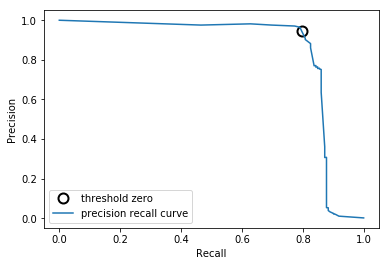

In [58]:
#5 Precision Recall Curve
precision, recall, thresholds=precision_recall_curve(y_test, forest_model.predict_proba(x_test)[:,1])

# Tree models have no decision_function() attribute, unlike in logistic regression we have both


# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds-0.5))


plt.plot( recall[close_zero],precision[close_zero], 'o', markersize=10, label="threshold zero", fillstyle="none", c='k', mew=2)
plt.plot(recall, precision, label="precision recall curve")

plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend(loc="best")


Average_Precision=average_precision_score(y_test, forest_model.predict_proba(x_test)[:,1])


print("Average Precision:\n{}".format(Average_Precision));


# The default threshold (Decision function=0 or Probabily=0.5 appears to be good)

Text(0.5, 0, 'Threashold')

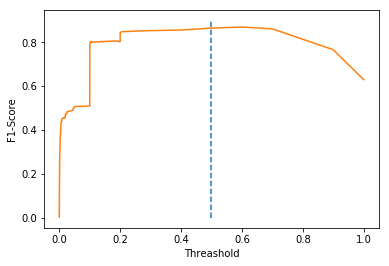

In [65]:
# 5.1 F1-Score under different Precision:

# As an example: we can have a side by side view of Precision, Recall and F1-Score for each Threshold
# SK-Learn made up a Precision=1, Recall=0 case to make the plot looks nice at the end point, in actual, this point doesn't
#   exist. As one is zero, the other is zero too. Calculation takes off this artifical point so we can have thresholds added
Information_Combine=[precision[:-1], recall[:-1], thresholds]
Information_Combine_DF=pd.DataFrame(Information_Combine)
Performance=Information_Combine_DF.T
Performance.columns=['Precision', 'Recall', 'Threshold']

Performance['F1-Score']=2*Performance['Precision']*Performance['Recall']/(Performance['Precision']+Performance['Recall'])
plt.plot([0.5, 0.5], [0, 0.9], linestyle='--')
plt.plot(Performance['Threshold'], Performance['F1-Score'])

plt.ylabel("F1-Score")
plt.xlabel("Threashold")

# The threashold bringing the highest F1-Score is ok with default probability 0.5 (or 0.6)

AUC score w Unbalanced data:
0.9504425185669552


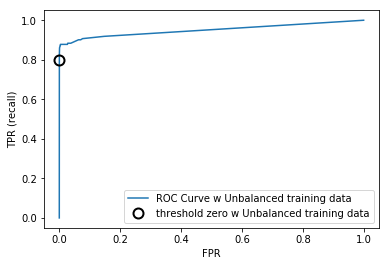

In [75]:
#6. AUC curve and Score

fpr, tpr, thresholds = roc_curve(y_test, forest_model.predict_proba(x_test)[:,1])
plt.plot(fpr, tpr, label="ROC Curve w Unbalanced training data")

plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds-0.5))


plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
label="threshold zero w Unbalanced training data", fillstyle="none", c='k', mew=2)

plt.legend(loc=4)


auc=roc_auc_score(y_test,  forest_model.predict_proba(x_test)[:,1])


print("AUC score w Unbalanced data:\n{}".format(auc))


Text(0, 0.5, 'True probability with Test data')

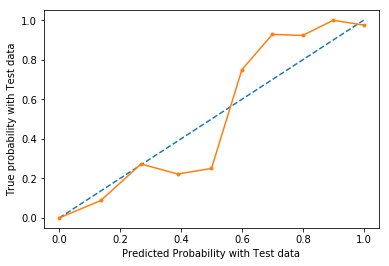

In [109]:
#7. Calibration Curve/ Reliability Diagram

# Test set predicted probabily
probs=forest_model_fitted.predict_proba(x_test)[:,1] # Probility Estimate
prob_true, prob_pred=calibration_curve(y_test, probs, n_bins=10, normalize=True)


# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
plt.plot(prob_pred, prob_true, marker='.')


plt.xlabel("Predicted Probability with Test data")
plt.ylabel("True probability with Test data")


# the plot shows model appears to be fairly calibrated

## #8.Fit and improve the model with Calibrated prediction

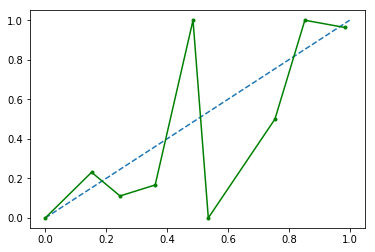

In [110]:
# Calibration classifier/model, built in additional to other models.
# With this class, the base_estimator is fit on the train set of the cross-validation generator and 
#      the test set is used for calibration. The probabilities for each of the folds are then averaged for prediction.

calibrated=CalibratedClassifierCV(forest_model, method='isotonic', cv=5) 
calibrated.fit(x_train, y_train) # fit calibration model

probs_Ca = calibrated.predict_proba(x_test)[:, 1]


prob_true_Ca, prob_pred_Ca=calibration_curve(y_test, probs_Ca, n_bins=10, normalize=True)


# plot perfectly calibrated- the diagnal
plt.plot([0, 1], [0, 1], linestyle='--')  # graph 1
# plot calibrated reliability
plt.plot(prob_pred_Ca, prob_true_Ca, marker='.', color='green') # graph 2

# Calibrated cross-validation didn't improve test set calibration, though it found me a model with best calibration 
#     based on the train/validation set.

In [94]:

print("Classification report with uncalibrated model")
print(classification_report(y_test, forest_predict))

print("")

print("Classification report with calibrated model")
calibrated_predict=calibrated.fit(x_train, y_train).predict(x_test)
print(classification_report(y_test, calibrated_predict))

# Results are very similar before and after calibration

Classification report with uncalibrated model
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99511
           1       0.96      0.79      0.87       172

   micro avg       1.00      1.00      1.00     99683
   macro avg       0.98      0.90      0.93     99683
weighted avg       1.00      1.00      1.00     99683


Classification report with calibrated model
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99511
           1       0.93      0.80      0.86       172

   micro avg       1.00      1.00      1.00     99683
   macro avg       0.97      0.90      0.93     99683
weighted avg       1.00      1.00      1.00     99683



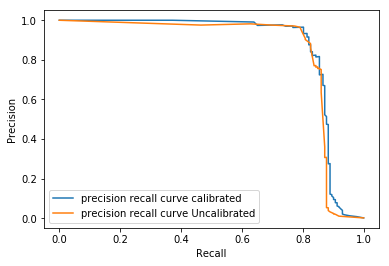

In [98]:
precision_Ca, recall_Ca, thresholds_Ca=precision_recall_curve(y_test, calibrated.predict_proba(x_test)[:, 1])

plt.plot(recall_Ca, precision_Ca, label="precision recall curve calibrated")
plt.plot(recall, precision, label="precision recall curve Uncalibrated")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc='best')



AUC score w Calibrated data:
0.9788890932473749
AUC score w Uncalibrated data:
0.9504425185669552


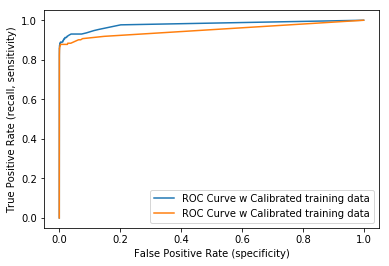

In [108]:
# ROC Curve

fpr_Ca, tpr_Ca, thresholds_Ca = roc_curve(y_test, calibrated.predict_proba(x_test)[:, 1])
plt.plot(fpr_Ca, tpr_Ca, label="ROC Curve w Calibrated training data")

plt.plot(fpr, tpr, label="ROC Curve w Calibrated training data")


plt.xlabel("False Positive Rate (specificity)")
plt.ylabel("True Positive Rate (recall, sensitivity)")

plt.legend()


auc_Ca=roc_auc_score(y_test,  calibrated.predict_proba(x_test)[:, 1])
auc=roc_auc_score(y_test,  forest_model.predict_proba(x_test)[:,1])

print("AUC score w Calibrated data:\n{}".format(auc_Ca))
print("AUC score w Uncalibrated data:\n{}".format(auc))

Conclusion:

In our randome forest model, 
1. Grid-search Cross-Validation chose to use unbalanced training data and minimize entropy to come up a model with highest f1-score.
2. Calibrated model didn't improve calibration over test data
3. However, Calibrated model does bring better model performance by observing ROC curve and Precision-Recall curve

Therefore, we will choose calibration to improve our Random Forest model performance